**TP BDM : NLP - Analyse des sentiments sur Consumer Reviews of Amazon Products -**

Réalisé par : 
BUAZZOUNI Syphax et HACHEMI Hayat 

Juin 2020 

#**Résumé**


Pour connaitre l'opinion publique des clients sur leurs produits , les entreprises exploitent les commentaires et feedbacks de leurs consommateurs et appliquent une des techniques de NLP ( Natural language processing ) qui est l'analyse des sentiments , le sujet de ce TP . 

Durant ce TP , nous étudions  Naïve Bayes, Random Forest et Support Vector Machines implémentés dans Apache Spark sur un dataset d'Avis des consommateurs sur les produits Amazon afin de prédire les sentiments de ces derniers ( positif ou négatif )  et de comparer la performance de ses classifieurs a la fin .

**Mots clés**: Sentiment analysis , machine
learning, NaiveBayes ( NB ) , support vector machine (SVM) , Random Forest (RF ) , Apache Spark , Natural Langauge Processing . 

# **Introduction**

## 1- NLP , C'est quoi ?

Le traitement du langage naturel NLP (Natural Language Processing) est un domaine multidisciplinaire impliquant la linguistique, l&#39;informatique et l&#39;intelligence artificielle visant à permettre aux ordinateurs de comprendre , interpréter et manipuler le langage humain .

**L'analyse des sentiments** est l'un des domaines les plus importants de la PNL . C'est l'interprétation et la classification des émotions (positives, négatives et neutres) dans les données de texte à l'aide de techniques d'analyse de texte. Il permet aux entreprises d'identifier le sentiment des clients envers les produits, les marques ou les services dans les conversations et les commentaires en ligne et donc de définir leurs stratégie et prendre des décisions .


## 2- Etapes de prétraitement en NLP 
  Afin de faire de l'analyse de sentiment non supervisé , on aura besoin d'attributs quantitatifs ce que généralement les dataset n'offre pas, car de base la plus part des dataset contient deux colonnes importante pour l'analyse qui sont le **review** qui represente l'avis de l'utilisateur sous format texte et une autre colonne qui est le **rating** ou c'est l'annotation du review (pas exemple good/bad ou un score de 1 a 5 ,...).   

Donc pour transformer ces attributs qualitatifs en attributs quantitatifs ,  on doit passer par un certain nombre d'opérations sur le texte pour le transformer du texte simple en une suite de features ( voir le rapport joint pour plus de détails ) . 

Ces étapes (assez connues en analyse de texte) sont les suivantes:
1. **Passage en minuscule** 
1. **Tokenizer**: C'est pour transformer un texte , en un tableau de mots {texte -> (mot1,mot2,...,motn)} ([source](https://spark.apache.org/docs/latest/ml-features.html#tokenizer))
2. **Remove Stopword**: C'est pour enlever les mots vides (qui n’apportent aucune information ) comme : the, is, at, which, et,on,... dans la liste de mots ([source ](https://https://spark.apache.org/docs/latest/ml-features.html#stopwordsremover))
3. **TF-IDF** : pour Term frequency-inverse document frequency c'est une méthode de vectorisation de texte largement utilisée dans l'exploration de texte pour refléter l'importance d'un terme d'un document dans le corpus (ensemble de documents).Notons un terme par **t**, un document par **d** et le corpus par **D**, cette methode passe par 3 etapes : 
  * Term frequency : **TF(t,d)** est le nombre de fois que ce terme **t** apparaît dans le document **d**
  * Inverse document frequency : 
  ```
    IDF(t,D)= log( |D|+1 / (DF(t,D)+1 )
  ```
  Avec **DF (t, D)** est le nombre de documents dans le corpus **D** contenant le terme **t** ,et **| D |** est le nombre total de documents dans le corpus **D**.
  Cette partie est la plus important car si nous utilisons uniquement la fréquence des termes pour mesurer l'importance, il est très facile de surestimer les termes qui apparaissent très souvent mais qui contiennent peu d'informations sur le document, par ex. «a», «le» et «de». Alors que si un terme apparaît très souvent dans le corpus, cela signifie qu'il ne contient pas d'informations spéciales sur un document particulier ce qui le IDF permet de calculer
  * TF-IDF :
  ```
    TFIDF(t,d,D)= TF(t,d) X IDF(t,D)
  ```
  ([source](https://spark.apache.org/docs/latest/ml-features.html#tf-idf))

## 3- Travail demandé 

Au sein de ce TP , on fera une application d'anlayse des sentiments sur les feedbacks des clients sur quelques produits d'Amazon . 

On a choisi comme dataset , [Consumer Reviews of Amazon Products](https://www.kaggle.com/datafiniti/consumer-reviews-of-amazon-products) une liste de plus de 34 000 avis sur des produits Amazon comme le Kindle, Fire TV, etc.

L'application se fera sur un environnement **Spark** en utilisant trois algorithmes du Machine learning , **NaiveBayes** , **SVM** et **RF** ... 

# **Mise en place de SPARK dans Colab**

Pour exécuter spark dans Colab, nous devons d'abord installer toutes les dépendances dans l'environnement Colab, à savoir Apache **Spark 2.4.5** avec hadoop 2.7, **Java 8** et **Findspark** pour localiser l'étincelle dans le système.

## 1- Téléchargement de JDK et SPARK

In [ ]:
!rm -fr spark-* #supprimer spark si il existe deja (a faire seulement si on le veut)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
!tar xf spark-2.4.5-bin-hadoop2.7.tgz #extraire spark 


> On aura à la fin dans notre répertoire Colab un dossier **spark-2.4.5-bin-hadoop2.7**



---



In [ ]:
!ls

consumer-reviews-of-amazon-products.zip  spark-2.4.5-bin-hadoop2.7
sample_data				 spark-2.4.5-bin-hadoop2.7.tgz


## 2- Edition des variable d'environement 

Après avoir installer Spark et Java dans Colab, il faut definir le chemin de l'environnement qui permettera d'exécuter Pyspark dans notre environnement Colab.Pour cela, il faut définir l'emplacement de Java et Spark en exécutant le code suivant:

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"
os.environ["PYSPARK_SUBMIT_ARGS"]="--master local[*] pyspark-shell"

## 3- Lancement du SPARK

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark import SparkContext

sp = SparkSession.builder.master("local[*]").getOrCreate()
sqlContext = SQLContext(sp.sparkContext)

## 4- Pour connaitre le temps d'exécution !!


In [ ]:
!pip install ipython-autotime

%load_ext autotime 
#une extension du Notebook permettant de donner le temps d'excution en bas de chaque zone de code de celui ci 


# **Decouverte du DataSet**

## 1- Téléchargment du dataset 

Premièrement , On instalera l'api Kaggle qui nous permettra de manière tres simple de telecharger n'importe quelle dataset de Kaggle directement en ligne de commande  

In [ ]:
!pip install -q kaggle

time: 2.86 s


Aprés instalation , on doit s'authentifier a Kaggle pour l'utiliser . Pour cela , on utilisera un fichier kaggle.json qui contienne nos identifiants.
Ce fichier sera uploadé dans le dossier **.kaggle** 

In [ ]:
from google.colab import files
files.upload() #pour uploader kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hayathachemi","key":"xxxxxxxxxxxxxxxxxxxxxx"}'}

time: 8.53 s


In [ ]:
!mkdir .kaggle
!mv kaggle.json .kaggle
!ls -lha

mkdir: cannot create directory ‘.kaggle’: File exists
total 239M
drwxr-xr-x  1 root root 4.0K Jun  6 19:27 .
drwxr-xr-x  1 root root 4.0K Jun  6 15:50 ..
drwxr-xr-x  1 root root 4.0K Jun  2 16:14 .config
-rw-r--r--  1 root root  17M Jun  6 15:50 consumer-reviews-of-amazon-products.zip
drwxr-xr-x  2 root root 4.0K Jun  6 19:27 .kaggle
drwxr-xr-x  1 root root 4.0K May 29 18:19 sample_data
drwxr-xr-x 13 1000 1000 4.0K Feb  2 19:47 spark-2.4.5-bin-hadoop2.7
-rw-r--r--  1 root root 222M Feb  2 20:27 spark-2.4.5-bin-hadoop2.7.tgz
time: 5.01 s


In [ ]:

!ls -lha .kaggle

total 12K
drwxr-xr-x 2 root root 4.0K Jun  6 19:27 .
drwxr-xr-x 1 root root 4.0K Jun  6 19:27 ..
-rw-r--r-- 1 root root   68 Jun  6 19:26 kaggle.json
time: 2.94 s


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/.kaggle"

time: 1.92 ms


Maintenant , c'est fait !! On pourra télécharger n'importe quel dataset ... 

In [ ]:
!kaggle datasets download -d datafiniti/consumer-reviews-of-amazon-products

consumer-reviews-of-amazon-products.zip: Skipping, found more recently modified local copy (use --force to force download)
time: 2.09 s


On remarque que le fichier zip suivant **consumer-reviews-of-amazon-products.zip** a été rajouté

In [ ]:
!ls

consumer-reviews-of-amazon-products.zip  spark-2.4.5-bin-hadoop2.7
sample_data				 spark-2.4.5-bin-hadoop2.7.tgz
time: 2.03 s


On le décompresse dans le dossier **data** 

In [ ]:
!unzip \*.zip  -d /data

Archive:  consumer-reviews-of-amazon-products.zip
replace /data/1429_1.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: time: 1min 38s


In [ ]:
!ls -lh /data

total 396M
-rw-r--r-- 1 root root  47M Sep 20  2019 1429_1.csv
-rw-r--r-- 1 root root  95M Sep 20  2019 Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv
-rw-r--r-- 1 root root 254M Sep 20  2019 Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv
time: 1.94 s


le dataset contient 3 tables , nous on utlisera le dernier **Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19** qui est le plus a jour (mai 2019) et le plus grand (28 000 lignes).
Et voici sa description :


> Cet ensemble de données est une liste de plus de 28 000 avis de consommateurs pour des produits Amazon tels que le Kindle, le Fire TV Stick , etc ,extrait de la base de données de produits de Datafiniti mise à jour entre février 2019 et avril 2019. Chaque ligne de produits inclut le nom Amazon dans le champ Marque et fabricant. Tous les champs de cet ensemble de données ont été aplatis, certains omis, pour rationaliser l'analyse de données. Cette version est un exemple d'un grand ensemble de données. L'ensemble de données complet est disponible via Datafiniti (Source Kaggle).





## 3 - Parcours du dataset




le dataset contient 3 tables , nous on utlisera pendant ce TP  le dernier **Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19** qui est le plus a jour (mai 2019) et le plus grand (28 000 lignes) . 

Cet ensemble de données est une liste de plus de 28 000 avis de consommateurs pour des produits Amazon tels que le Kindle, le Fire TV Stick , etc ,extrait de la base de données de produits de Datafiniti mise à jour entre février 2019 et avril 2019. Chaque ligne de produits inclut le nom Amazon dans le champ Marque et fabricant. Tous les champs de cet ensemble de données ont été aplatis, certains omis, pour rationaliser l'analyse de données. Cette version est un exemple d'un grand ensemble de données. L'ensemble de données complet est disponible via Datafiniti (Source Kaggle)",

In [ ]:
data = sqlContext.read.format('csv').options(header='true', inferschema='true').load('/data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

time: 12.9 s


In [ ]:
print('Le dataset a '+str(data.count())+' lignes et '+ str(len(data.columns)))

Le dataset a 28332 lignes et 24
time: 1.4 s


Les colonnes du dataset :

In [ ]:
data.printSchema()

root
 |-- id: string (nullable = true)
 |-- dateAdded: timestamp (nullable = true)
 |-- dateUpdated: timestamp (nullable = true)
 |-- name: string (nullable = true)
 |-- asins: string (nullable = true)
 |-- brand: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- primaryCategories: string (nullable = true)
 |-- imageURLs: string (nullable = true)
 |-- keys: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- manufacturerNumber: string (nullable = true)
 |-- reviews.date: string (nullable = true)
 |-- reviews.dateSeen: string (nullable = true)
 |-- reviews.didPurchase: string (nullable = true)
 |-- reviews.doRecommend: boolean (nullable = true)
 |-- reviews.id: string (nullable = true)
 |-- reviews.numHelpful: integer (nullable = true)
 |-- reviews.rating: integer (nullable = true)
 |-- reviews.sourceURLs: string (nullable = true)
 |-- reviews.text: string (nullable = true)
 |-- reviews.title: string (nullable = true)
 |-- reviews.username: st

In [ ]:
#Envelver les points "." des noms de colonne car ca provoque une erreur a la selection
newColumns = []
for col in data.columns :
    newCol = col.strip()
    newCol = newCol.replace('.','') 
    newColumns.append(newCol)
len(newColumns)
data = data.toDF(*newColumns)

time: 44.9 ms


On s'intéresse qu'aux deux colonnes : Reviews et Rating 

**Review Text**: Texte feedback client.

**Rating**: Variable entière ordinale positive pour le score produit accordé par le client de 1 pire à 5 meilleur .

In [ ]:
data = data.selectExpr('reviewstext as reviews','reviewsrating as rating')
dataPD = data.toPandas()

time: 4.36 s


In [ ]:
dataPD.info() #pour voir le nombre de valeur nulle

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  28332 non-null  object
 1   rating   28332 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 332.1+ KB
time: 15 ms




> On remarque qu'il **y'a aucune valeur nulle** dans le dataset ! 


## 4- Exploration du dataset

In [ ]:
dataPD.groupby("rating").count()

,reviews
rating,
0,91
1,965
2,617
3,1205
4,5621
5,19831
16,1
44,1


time: 31.1 ms




> on remarque qu'il y'a **2 lignes qui posent problème** avec comme valeur **16** et **44** , donc on les supprime




In [ ]:
data = data.filter(data.rating<=5) #enelver toutes les lignes qui ont rating > 5
dataPD = data.toPandas()
dataPD.groupby("rating").count()

,reviews
rating,
0,91
1,965
2,617
3,1205
4,5621
5,19831


time: 2.47 s


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f7501780588>],
      dtype=object)

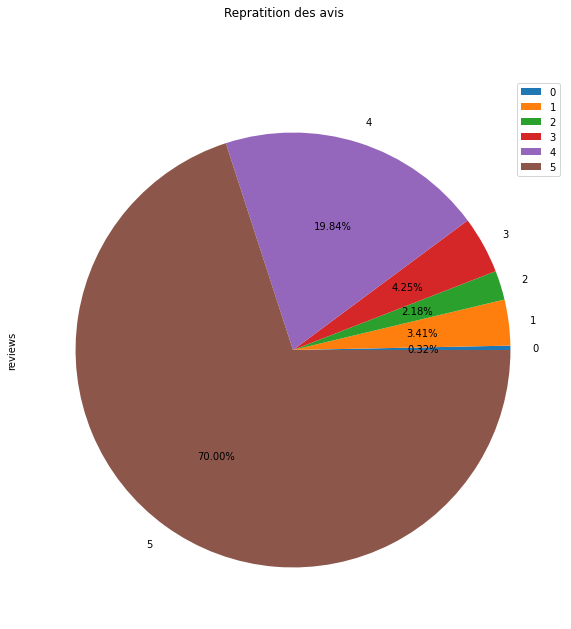

time: 200 ms


In [ ]:
dataPD.groupby("rating").count().plot.pie(subplots=True,figsize=(10,10),title="Repratition des avis",autopct='%.2f%%')



> On remarque le dataset est ***déséquilibré*** avec majoraitairement des avis **favorables( à 70% )** , ce qui peut poser un gros probleme dans l'apprentisage 



# **Prétraitement du dataset**

## 1- Annotation du dataset

Comme nous n'avons pas de colonne qui montre le sentiment : positif ou négatif , on a défini une nouvelle colonne de sentiment. Pour ce faire, on a supposé que les avis qui avaient une note de 4 ou plus étaient positifs et 3 ou moins étaient négatifs .

In [ ]:
from pyspark.sql import functions as f
# Rating of 4 or higher -> positive (1)
# Rating of  3 or lower -> negative (0)

data_new=data.withColumn('Sentiment', f.when(f.col('Rating') >=4,1).otherwise(0))

time: 106 ms


In [ ]:
data_new.printSchema()

In [ ]:
data_repartition = data_new.select('reviews','Sentiment').toPandas().groupby("Sentiment").count()
data_repartition

,reviews
Sentiment,
0,2878
1,25452


time: 2.41 s


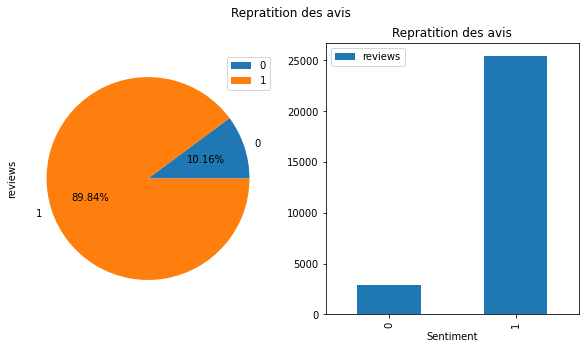

time: 352 ms


In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
data_repartition.plot.pie(ax=axes[0],subplots=True,title="Repratition des avis",autopct='%.2f%%')
data_repartition.plot.bar(ax=axes[1],title="Repratition des avis")



> Comme on peut voir le dataset extrainement **unbalanced**



## 2- Prétraitement du texte ( Review text)

Avant de pouvoir être utilisable, la colone review  doit subir un prétraitement , et cela en implémentant les étapes de prétraitement du texte vues auparavant

In [ ]:
from pyspark.ml.feature import HashingTF, IDF,StopWordsRemover,Tokenizer, CountVectorizer

time: 134 ms


**a-Passage en minuscule** :

In [ ]:
from pyspark.sql.functions import lower, col
data_new=data_new.select("*", lower(col('reviews')))


time: 25.9 ms


In [ ]:
data_new = data_new.selectExpr('lower(reviews) as reviews','rating','Sentiment')

time: 49.5 ms


In [ ]:
data_new.show()

+--------------------+------+---------+
|             reviews|rating|Sentiment|
+--------------------+------+---------+
|i order 3 of them...|     3|        0|
|bulk is always th...|     4|        1|
|well they are not...|     5|        1|
|seem to work as w...|     5|        1|
|these batteries a...|     5|        1|
|bought a lot of b...|     5|        1|
|ive not had any p...|     5|        1|
|well if you are l...|     5|        1|
|these do not hold...|     3|        0|
|amazonbasics aa a...|     4|        1|
|i find amazon bas...|     5|        1|
|when i first star...|     3|        0|
|use it for my fis...|     5|        1|
|just got em so i ...|     5|        1|
|we have many thin...|     5|        1|
|thankful that i w...|     5|        1|
|i don't know if i...|     1|        0|
|in my opinion the...|     2|        0|
|they don't last a...|     4|        1|
|bought these batt...|     3|        0|
+--------------------+------+---------+
only showing top 20 rows

time: 296 ms


**b-Tokenisation:**

In [ ]:

tokenizer = Tokenizer(inputCol="reviews", outputCol="words") # "review"==> ("word1","word2",...,"wordn")

time: 23.8 ms


**c-Retrait des stopwords:**

In [ ]:
#List of stop words 
#Source :https://gist.github.com/sebleier/554280
add_stopwords=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]

time: 5.24 ms


In [ ]:
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filltred_words").setStopWords(add_stopwords)

time: 103 ms


**e-TF-IDF:**

In [ ]:
#1-TF
countVectors = CountVectorizer(inputCol="filltred_words", outputCol="rawFeatures", vocabSize=10000, minDF=5) #("word1","word2",...,"wordn") -> (nb1,nb2,...,nbn)

#une autre methode qui fait la meme chose que countVectors mais de maniere diffente
#hashingTF = HashingTF(inputCol="filltred_words", outputCol="rawFeatures", numFeatures=20) 

#2-TF-IDF
idf = IDF(inputCol="rawFeatures", outputCol="features")

time: 29.2 ms




> Une bonne pratique pour automatiser une suite de traitement sur une meme donnée est d'utiliser les **Piplines de spark** 





In [ ]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[tokenizer, stopwordsRemover,countVectors,idf])
pipelineFit = pipeline.fit(data_new)
dataset = pipelineFit.transform(data_new)
dataset.show(5)

+--------------------+------+---------+--------------------+--------------------+--------------------+--------------------+
|             reviews|rating|Sentiment|               words|      filltred_words|         rawFeatures|            features|
+--------------------+------+---------+--------------------+--------------------+--------------------+--------------------+
|i order 3 of them...|     3|        0|[i, order, 3, of,...|[order, 3, one, i...|(5600,[12,24,90,9...|(5600,[12,24,90,9...|
|bulk is always th...|     4|        1|[bulk, is, always...|[bulk, always, le...|(5600,[11,71,101,...|(5600,[11,71,101,...|
|well they are not...|     5|        1|[well, they, are,...|[well, duracell, ...|(5600,[9,27,121,1...|(5600,[9,27,121,1...|
|seem to work as w...|     5|        1|[seem, to, work, ...|[seem, work, well...|(5600,[1,9,19,27,...|(5600,[1,9,19,27,...|
|these batteries a...|     5|        1|[these, batteries...|[batteries, long,...|(5600,[1,9,16,80,...|(5600,[1,9,16,80,...|
+-------

## Scission du dataset

In [ ]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

time: 29 ms


In [ ]:
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))

Training Dataset Count: 19939
Test Dataset Count: 8391
time: 10 s


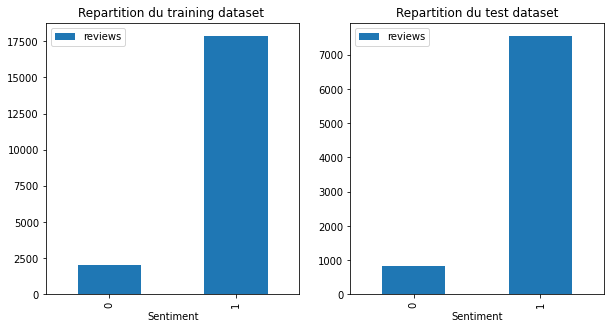

time: 9.19 s


In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10,5))
trainingData.select('reviews','Sentiment').toPandas().groupby("Sentiment").count().plot.bar(ax=axes[0],title="Repartition du training dataset ")
testData.select('reviews','Sentiment').toPandas().groupby("Sentiment").count().plot.bar(ax=axes[1],title="Repartition du test dataset")

# **Construction des Modèles**

## 1- Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes
#Spécifie la colonne des "features" et de la sortie "rating" 
nb = NaiveBayes(smoothing=1).setLabelCol('Sentiment').setFeaturesCol('features') 
modelNB = nb.fit(trainingData)

time: 8.08 s


## 2- SVM

In [ ]:
from pyspark.ml.classification import LinearSVC

lsvc = LinearSVC(maxIter=10, regParam=0.1).setLabelCol('Sentiment').setFeaturesCol('features')

modelSVM = lsvc.fit(trainingData)

time: 1min 27s


## 3- RF

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol="features").setLabelCol('Sentiment')

modelRF = rf.fit(trainingData)


time: 34.2 s


# **Evaluation des Modèles**

In [ ]:
import seaborn as sns

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import classification_report, confusion_matrix

time: 357 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


L'évaluation sera faite avec : 

> **Taux d'exactitude (accuracy score)**: La proportion d’instances qui ont été classées correctement .

> **Matrice de confusion** :Une matrice de confusion fournit un résumé des résultats prédictifs d'un problème de classification. Les prédictions correctes et incorrectes sont résumées dans un tableau avec leurs valeurs et classifiées par classe.

> **Rapport de classification** : Un rapport de classification montre une représentation des principales mesures de classification par classe. Cela donne une intuition plus profonde du comportement du classificateur par rapport à la précision globale, ce qui peut masquer les faiblesses fonctionnelles d'une classe d'un problème multiclasse . 

## 1-NaiveBayes

### **Prédictions** 

In [ ]:
predNB = modelNB.transform(testData)

time: 105 ms


In [ ]:
predNB.select(['reviews','Sentiment','prediction','probability']).show()

+--------------------+---------+----------+--------------------+
|             reviews|Sentiment|prediction|         probability|
+--------------------+---------+----------+--------------------+
|"although this wa...|        1|       1.0|[2.50924744342443...|
|"as a bluetooth s...|        1|       1.0|      [2.5E-323,1.0]|
|"beautiful hd res...|        1|       1.0|[3.54822733751079...|
|"best buy was run...|        1|       1.0|[2.38768034584361...|
|"bought this for ...|        1|       1.0|[1.59346271111470...|
|"despite not bein...|        1|       1.0|[1.30190129574265...|
|"despite not bein...|        1|       1.0|[1.30190129574265...|
|"easy to hold, ac...|        1|       1.0|[1.05210808293828...|
|"fire kids editio...|        1|       1.0|[2.44787331789275...|
|"first bought the...|        1|       1.0|[2.79483044034436...|
|"for the price th...|        1|       1.0|[1.05242741619910...|
|"for under $100 t...|        1|       1.0|[4.40404957254763...|
|"gave as a gift.d...|   

### **Accuracy score** 

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol="Sentiment", predictionCol="prediction", metricName="accuracy")
accuracyNB = evaluator.evaluate(predNB)
print("Taux de d'exactitude = %g" % (accuracyNB))
print("Taux d'erreur = %g" % (1.0 - accuracyNB))

Taux de d'exactitude = 0.887737
Taux d'erreur = 0.112263
time: 8.32 s


> Avec NaiveBayes , on a un taux d'exactitude ( accuracy score )  de **88 %** , Il semble se révéler globalement peut performant ..  

Essayons de voir plus de détails .... !

### **Matrice de confusion** 

In [ ]:
sentiment = predNB.select(['Sentiment']).collect()
predictionsNB = predNB.select(['prediction']).collect()
naive_bayes_cm=confusion_matrix(sentiment, predictionsNB)

time: 8.68 s


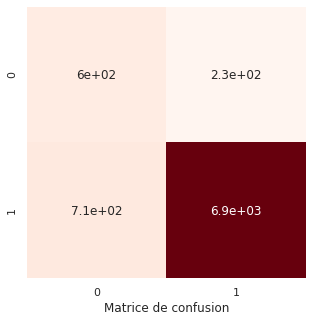

time: 153 ms


In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
p=sns.heatmap(naive_bayes_cm, annot = True, cmap="Reds",cbar=False)
p.axes.xaxis.label.set_text("Matrice de confusion")

**Interprétation** :

* Vrai positif: 6900 résultats sont prédit positif et c'est vrai.

* Vrai négatif: 600 résultats sont prédit négatif et c'est vrai.

* Faux positif(erreur de type 1): 710  résultats sont prédit positif et c'est faux.

* Faux négatif (erreur de type 2): 230 résultats sont prédit négatif et c'est faux.


### **Classification Report** 

In [ ]:
print(classification_report(sentiment, predictionsNB))

              precision    recall  f1-score   support

           0       0.46      0.72      0.56       830
           1       0.97      0.91      0.94      7561

    accuracy                           0.89      8391
   macro avg       0.71      0.81      0.75      8391
weighted avg       0.92      0.89      0.90      8391

time: 286 ms


> On remarque qu'on a une faible précision :  VN/(VN+FN)  **(46%)** sur **la classe négative (0)** , donc les instances négatives (classe 0)  ne sont pas classées correctement, ce qui entraîne un grand nombre d'instances positives qui sont réellement négatives . 

## 2- SVM

### **Prédictions** 

In [ ]:
predSVM = modelSVM.transform(testData)

time: 78.6 ms


In [ ]:
predSVM.select(['reviews','Sentiment','prediction']).show()

+--------------------+---------+----------+
|             reviews|Sentiment|prediction|
+--------------------+---------+----------+
|"although this wa...|        1|       1.0|
|"as a bluetooth s...|        1|       1.0|
|"beautiful hd res...|        1|       1.0|
|"best buy was run...|        1|       1.0|
|"bought this for ...|        1|       1.0|
|"despite not bein...|        1|       1.0|
|"despite not bein...|        1|       1.0|
|"easy to hold, ac...|        1|       1.0|
|"fire kids editio...|        1|       1.0|
|"first bought the...|        1|       1.0|
|"for the price th...|        1|       1.0|
|"for under $100 t...|        1|       1.0|
|"gave as a gift.d...|        1|       1.0|
|"had to chose bet...|        1|       1.0|
|"having family me...|        1|       1.0|
|"i added to a ""d...|        1|       1.0|
|"i am an ""old"" ...|        1|       1.0|
|"i bought the 8""...|        1|       1.0|
|"i bought this am...|        1|       1.0|
|"i bought this as...|        1|

### **Accuracy score**

In [ ]:
accuracySVM = evaluator.evaluate(predSVM)
print("Taux d'exactitude  = %g" % (accuracySVM))
print("Taux d'erreur = %g" % (1.0 - accuracySVM))

Taux d'exactitude  = 0.936718
Taux d'erreur = 0.0632821
time: 7.51 s


> Avec SVM , on a un taux d'exactitude ( accuracy score ) de **93 %** , Il semble se révéler globalement efficace , mieux que celui de NaiveBayes ..

Essayons de voir plus de détails .... !

### **Matrice de confusion**

In [ ]:
sentiment = predSVM.select(['Sentiment']).collect()
predictionsSVM = predSVM.select(['prediction']).collect()
SVM_cm=confusion_matrix(sentiment, predictionsSVM)

time: 7.84 s


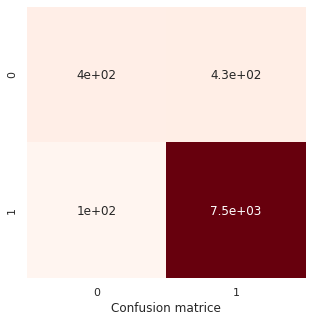

time: 147 ms


In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
p=sns.heatmap(SVM_cm, annot = True, cmap="Reds",cbar=False)
p.axes.xaxis.label.set_text("Confusion matrice")

**Interprétation**: 

* Vrai positif: 7500 résultats sont prédit positif et c'est vrai.

* Vrai négatif: 400 résultats sont prédit négatif et c'est vrai.

* Faux positif(erreur de type 1): 100 résultats sont prédit positif et c'est faux.

* Faux négatif (erreur de type 2): 430 résultats sont prédit négatif et c'est faux.


### **Classification Report**

In [ ]:
print(classification_report(sentiment, predictionsSVM))

              precision    recall  f1-score   support

           0       0.80      0.48      0.60       830
           1       0.95      0.99      0.97      7561

    accuracy                           0.94      8391
   macro avg       0.87      0.73      0.78      8391
weighted avg       0.93      0.94      0.93      8391

time: 299 ms


> On remarque qu'avec SVM , le problème de la faible précision sur la classe négative a été amélioré  , tandis que le rappel:VN/(VN+FP)  sur la meme classe a baissé  **(48%)** .

En général , ce Modèle n'est pas du tout performant sur la classe négatif , moyenne harmonique ( f1-score ) est faible **60%** . 

## 3- RF

### **Prédictions**

In [ ]:
predRF = modelRF.transform(testData)

time: 82.3 ms


In [ ]:
predRF.select(['reviews','Sentiment','prediction']).show()

+--------------------+---------+----------+
|             reviews|Sentiment|prediction|
+--------------------+---------+----------+
|"although this wa...|        1|       1.0|
|"as a bluetooth s...|        1|       1.0|
|"beautiful hd res...|        1|       1.0|
|"best buy was run...|        1|       1.0|
|"bought this for ...|        1|       1.0|
|"despite not bein...|        1|       1.0|
|"despite not bein...|        1|       1.0|
|"easy to hold, ac...|        1|       1.0|
|"fire kids editio...|        1|       1.0|
|"first bought the...|        1|       1.0|
|"for the price th...|        1|       1.0|
|"for under $100 t...|        1|       1.0|
|"gave as a gift.d...|        1|       1.0|
|"had to chose bet...|        1|       1.0|
|"having family me...|        1|       1.0|
|"i added to a ""d...|        1|       1.0|
|"i am an ""old"" ...|        1|       1.0|
|"i bought the 8""...|        1|       1.0|
|"i bought this am...|        1|       1.0|
|"i bought this as...|        1|

In [ ]:
predRF.groupBy('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       1.0| 8391|
+----------+-----+

time: 6.92 s


### **Accuracy score**

In [ ]:
accuracyRF = evaluator.evaluate(predRF)
print("Taux d'exactitude  = %g" % (accuracyRF))
print("Taux d'erreur = %g" % (1.0 - accuracyRF))

Taux d'exactitude  = 0.901084
Taux d'erreur = 0.0989155
time: 7.53 s


> Avec RF , on a un taux d'exactitude ( accuracy score ) de **90 %** , mieux que Naive Bayes mais moins performant que celui de SVM ..

Essayons de voir plus de détails .... !

### **Matrice de confusion**

In [ ]:
sentiment = predRF.select(['Sentiment']).collect()
predictionsRF = predRF.select(['prediction']).collect()
RF_cm=confusion_matrix(sentiment, predictionsRF)

time: 7.86 s


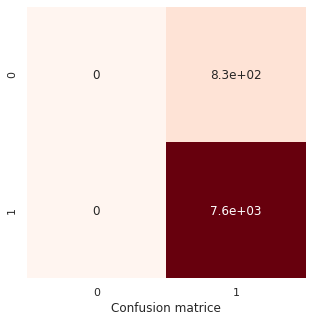

time: 154 ms


In [ ]:
sns.set(rc={'figure.figsize':(5,5)})
p=sns.heatmap(RF_cm, annot = True, cmap="Reds",cbar=False)
p.axes.xaxis.label.set_text("Confusion matrice")

**Interprétation** :

* Vrai positif: 7600 résultats sont prédit positif et c'est vrai.

* Faux négatif (erreur de type 2): 830 résultats sont prédit négatif et c'est faux.

> Le modele ne prédit pas les 0 : classe négative !!, car le dataset était trop désiquilibré 








### **Classification Report**

In [ ]:
print(classification_report(sentiment, predictionsRF))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       830
           1       0.90      1.00      0.95      7561

    accuracy                           0.90      8391
   macro avg       0.45      0.50      0.47      8391
weighted avg       0.81      0.90      0.85      8391

time: 287 ms


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#Conlusion générale 

- On remarque que SVM a des meilleures performances que NaiveBayes et Random Forest sur l'analyse des sentiments de ce dataset . 
- Les classes désiquilibrées ont affecté les performances des modeles , surtout en ce qui concerne RF qui prédit uniquement une seule classe . Pour cela , toujours il faut faire en sorte d'avoir le minimum de classes désiquilibrées .